### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import pandas as pd
from model import *

In [4]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.2.4-tf
TensorFlow version: 1.14.0


In [5]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [6]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [7]:
# Loading full images of desired resolution:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

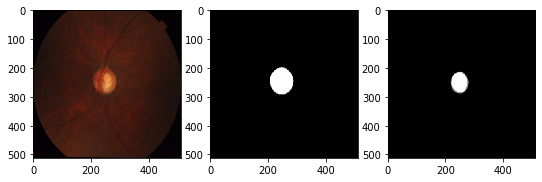

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [32]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.squeeze(img_train[0]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.squeeze(disc_train[0]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.squeeze(cup_train[0]), cmap=plt.cm.Greys_r)
plt.show()

img_train, cup_train, disc_train, disc_locations

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

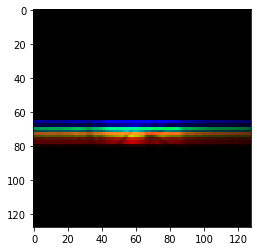

In [31]:
gen = data_generator(img_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)
plt.imshow(np.squeeze(batch[0][0]))

In [12]:
X_valid, Y_valid = next(data_generator(img_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))
len(X_valid), len(Y_valid)

(51, 51)

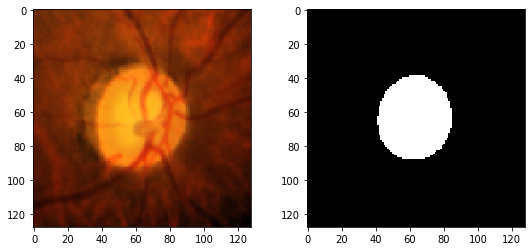

In [13]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.squeeze(X_valid[10]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(Y_valid[10]), cmap=plt.cm.Greys_r)
plt.show()

### Training and testing cup

In [ ]:
train(img_train, cup_train, disc_locations, 'cup_color', model, 1000)

### Visual check

image #0


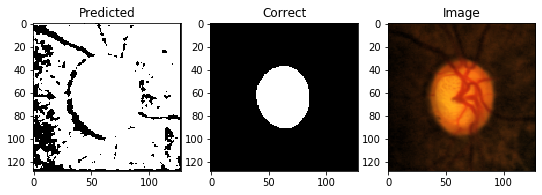

IOU: 0.1440112590789795
Dice: 0.2517654680919987
0.14401126
0.2517654680919987


In [15]:
pred_iou, pred_dice, pred_cup = predict(img_test, X_valid, Y_valid, model)
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Loading model

In [16]:
X_valid, Z_valid = next(data_generator(img_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

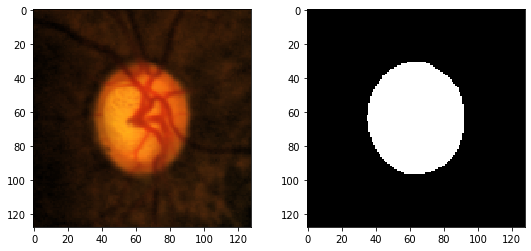

In [17]:
num = 1
for i in range(num):
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(X_valid[i]), cmap=plt.cm.Greys_r)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(Z_valid[i]), cmap=plt.cm.Greys_r)
    plt.show()
    print('=========================')

In [ ]:
train(img_train, disc_train, disc_locations, 'disc_color', model, 1000)

image #0


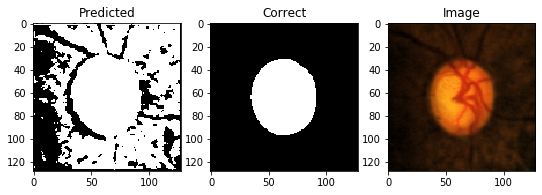

IOU: 0.2621583342552185
Dice: 0.41541274082407537
0.26215833
0.41541274082407537


In [21]:
pred_iou, pred_dice, pred_disc = predict(img_test, X_valid, Z_valid, model)
print(np.mean(pred_iou))
print(np.mean(pred_dice))

In [ ]:
cdrs = calculate_cdr(pred_cup, pred_disc)
areas = calculate_area(pred_cup, pred_disc)
d = {'cdr': cdrs, 'area': areas}
df = pd.DataFrame(data=d)
df
